## Import Library

In [1]:
import pandas as pd
import numpy as np
import nltk, re, string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Load the Data

In [2]:
raw_data = pd.read_excel('dataset.xlsx')  
raw_data

,title,label
0,[BENAR] Bahaya Daging Kurban Dibungkus Kresek ...,0
1,[BENAR] SPP SMA/SMK GRATIS JAWA TIMUR,0
2,"[BENAR] Dianggap Lecehkan Guru, Iklan Hago Dip...",0
3,[BENAR] Permen Jeli yang Dibuat dengan Gelatin...,0
4,[BENAR] Unggahan Hasil C1 Pleno TPS di Bangil ...,0
...,...,...
1435,"""AA Gym : Lebih baik pilih pemimpin koruptor t...",1
1436,"""Sebuah gambar dengan keterangan “Sultan Erdog...",1
1437,"""Restoran Padang ""Sederhana"" sedang merayakan ...",1
1438,"""Ini adalah binatang yang langka dan sangat be...",1


## Preprocessing

### Drop Duplicatte

In [3]:
clean_df = raw_data[raw_data['title'].duplicated()==False]
clean_df.reset_index(inplace=True)
clean_df

,index,title,label
0,0,[BENAR] Bahaya Daging Kurban Dibungkus Kresek ...,0
1,1,[BENAR] SPP SMA/SMK GRATIS JAWA TIMUR,0
2,2,"[BENAR] Dianggap Lecehkan Guru, Iklan Hago Dip...",0
3,3,[BENAR] Permen Jeli yang Dibuat dengan Gelatin...,0
4,4,[BENAR] Unggahan Hasil C1 Pleno TPS di Bangil ...,0
...,...,...,...
1416,1426,"""Pasukan Amerika Serikat sempat menyita dokume...",1
1417,1427,"""Game Pokemon Go yang marak di beberapa negara...",1
1418,1428,"""Teman2 sebaiknya bsk jgn kmna2 dulu, ada kaba...",1
1419,1431,“Dik Joko Widodo masih kuliah aja. Sy sudah ba...,1


In [4]:
news = clean_df['title'].to_numpy(dtype='str')
news

array(['[BENAR] Bahaya Daging Kurban Dibungkus Kresek Hitam',
       '[BENAR] SPP SMA/SMK GRATIS JAWA TIMUR',
       '[BENAR] Dianggap Lecehkan Guru, Iklan Hago Diprotes', ...,
       '"Teman2 sebaiknya bsk jgn kmna2 dulu, ada kabar akan ada demo karena tdk terima atas kemenangan ini. Bnyk polisi yg sdh siaga malam ini. Mohon untuk teman2 sebaiknya di rmh dulu, Info A1 dari bbrp teman di BIN, Densus dan Intel bbrp Kodam…di bbrp daerah Jabar, Jakarta dan terutama Solo…tercium plot akan ada pergerakan massa mirip 98…yg memprovokasi justru dari bbrp oknum grup 2 Kopassus yg loyal thd Prabowo…mohon waspada…Panglima dan Kapolri sdh tahu info Intelijen ini…makanya Kapolri sdh memberikan perintah tembak ditempat"',
       '“Dik Joko Widodo masih kuliah aja. Sy sudah bangun tol bersama Hutama Karya. Jd klo sekarang nerusin tol yg ada itu hanya penambahan. Jangan merasa bpk pembangunan dik jokowi. Krna bapak pembnguann masih melekat dihati rakyat adalah almarhum HM SOEHARTO Bkn yg lain. Ayo ber

In [5]:
## Ini run sekali aja, buat pertama kali, kalo udh mah comment aja
## nltk.download('stopwords')
##nltk.download('punkt')

In [6]:
#stopwords
stopwords = set(nltk.corpus.stopwords.words('indonesian'))
# slang words
slang = pd.read_csv('slang.csv')
slang_list = slang.to_numpy(dtype='str')

In [7]:
def unslang_word(word):
    if word not in slang_list[:,0]:
        return [word]
    
    index = slang_list[:,0].tolist().index(word)
    new_word = slang_list[index,1]
    
    return [w for w in new_word.split()]

In [8]:
word_dict = {}
processed_news = []

for a_news in news:
    
    # sentence segmentation
    sentences = nltk.tokenize.sent_tokenize(a_news)
    new_words = []
    
    for sentence in sentences:
        
        # punctuations and numbers to be removed, '@' to identify mentioned user, '-' to identify sentiment word
        remove = string.punctuation.replace('-','')+'"'+'0123456789'
        # replace word, remove non ASCII, remove punctuation, remove number, remove whitespaces, to lower
        folded = sentence.replace('&amp','&').replace('&', 'dan').replace('[BENAR]','').replace('[HOAX]','').replace('(HOAX)','').replace('-',' ').replace('\n',' ').encode('ascii','ignore').decode('ascii').translate(str.maketrans('','',remove)).strip().lower()
        # word tokenizing
        words = nltk.word_tokenize(folded)
        
        for word in words:
            for new_word in unslang_word(word):

                    # stopword removal
                    if new_word in stopwords:
                        continue

                    # add processed word
                    new_words.append(new_word)
                    if new_word in word_dict.keys():
                        word_dict[new_word] += 1
                    else:
                        word_dict[new_word] = 1
    
    processed_news.append(new_words)

processed_news

[['bahaya', 'daging', 'kurban', 'dibungkus', 'kresek', 'hitam'],
 ['spp', 'smasmk', 'gratis', 'jawa', 'timur'],
 ['dianggap', 'lecehkan', 'guru', 'iklan', 'hago', 'diprotes'],
 ['permen', 'jeli', 'gelatin', 'berasal', 'kulit', 'tulang', 'hewan'],
 ['unggahan',
  'hasil',
  'c',
  'pleno',
  'pemungutan',
  'suara',
  'bangil',
  'pasuruan',
  'berbeda',
  'hasil',
  'situng',
  'komisi',
  'pemelihan'],
 ['dituding',
  'tawarkan',
  'pekerjaan',
  'peretas',
  'situs',
  'komisi',
  'pemelihan',
  'kepolisian',
  'republik',
  'indonesia',
  'bantahan'],
 ['cokelat', 'mermaid', 'memakan', 'korban'],
 ['foto', 'prabowo', 'titiek', 'soeharto'],
 ['video',
  'petugas',
  'kpps',
  'coblosi',
  'kertas',
  'suara',
  'halmahera',
  'beredar'],
 ['imigrasi',
  'kota',
  'semarang',
  'tangkap',
  'warga',
  'negara',
  'asing',
  'pelaku',
  'kejahatan'],
 ['komisioner',
  'komisi',
  'pemelihan',
  'ilham',
  'saputra',
  'adik',
  'kandung',
  'yuga',
  'aden',
  'tim',
  'komunikasi',
  

## Bag of Words

In [9]:
word_dict

{'bahaya': 14,
 'daging': 14,
 'kurban': 3,
 'dibungkus': 2,
 'kresek': 3,
 'hitam': 12,
 'spp': 1,
 'smasmk': 2,
 'gratis': 16,
 'jawa': 104,
 'timur': 70,
 'dianggap': 18,
 'lecehkan': 2,
 'guru': 52,
 'iklan': 20,
 'hago': 15,
 'diprotes': 2,
 'permen': 43,
 'jeli': 2,
 'gelatin': 2,
 'berasal': 23,
 'kulit': 7,
 'tulang': 7,
 'hewan': 9,
 'unggahan': 5,
 'hasil': 48,
 'c': 7,
 'pleno': 2,
 'pemungutan': 10,
 'suara': 80,
 'bangil': 1,
 'pasuruan': 4,
 'berbeda': 14,
 'situng': 8,
 'komisi': 87,
 'pemelihan': 41,
 'dituding': 5,
 'tawarkan': 1,
 'pekerjaan': 11,
 'peretas': 1,
 'situs': 16,
 'kepolisian': 149,
 'republik': 103,
 'indonesia': 527,
 'bantahan': 1,
 'cokelat': 2,
 'mermaid': 1,
 'memakan': 10,
 'korban': 110,
 'foto': 84,
 'prabowo': 52,
 'titiek': 1,
 'soeharto': 3,
 'video': 101,
 'petugas': 23,
 'kpps': 3,
 'coblosi': 1,
 'kertas': 6,
 'halmahera': 3,
 'beredar': 41,
 'imigrasi': 3,
 'kota': 109,
 'semarang': 20,
 'tangkap': 5,
 'warga': 126,
 'negara': 141,
 'asing

In [10]:
max(word_dict.values())

527

In [11]:
value = {i for i in word_dict if word_dict[i]==122}
print("key by value:",value)

key by value: {'jokowi'}


In [12]:
len(processed_news)

1421

In [13]:
raw_data['label']

0       0
1       0
2       0
3       0
4       0
       ..
1435    1
1436    1
1437    1
1438    1
1439    1
Name: label, Length: 1440, dtype: int64

In [14]:
docs = [' '.join(t) for t in processed_news]
new_df = pd.DataFrame(docs, columns=['news'])
new_df['label'] = raw_data['label']
new_df

,news,label
0,bahaya daging kurban dibungkus kresek hitam,0
1,spp smasmk gratis jawa timur,0
2,dianggap lecehkan guru iklan hago diprotes,0
3,permen jeli gelatin berasal kulit tulang hewan,0
4,unggahan hasil c pleno pemungutan suara bangil...,0
...,...,...
1416,pasukan amerika serikat menyita dokumen rahasi...,1
1417,game pokemon go marak negara indonesia tanggap...,1
1418,teman besok kemana kabar demo terima kemenanga...,1
1419,dik joko widodo kuliah bangun tol hutama karya...,1


In [15]:
new_df['label'].value_counts()

1    843
0    578
Name: label, dtype: int64

In [16]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(new_df['news'], new_df['label'], test_size=0.2, random_state=24)

In [17]:
df_train = pd.DataFrame()
df_train['news'] = train_X
df_train['label'] = train_y
df_train

,news,label
892,aparat kepolisian sektor mimika menganiaya warga,1
880,fenomena equinox bikin suhu derajat celcius in...,1
1179,yogyakarta tim mahasiswa universitas islam ind...,0
406,polisi israel mencekik anak palestina mati sab...,1
917,tokoh isis syaikh al arifi masjid istiqlal,1
...,...,...
145,isu penculikan disertai pemerkosaan remaja bal...,0
343,prabowo subianto alami strok kali,0
192,knpi sumatra utara bantah terima mobil bekas d...,0
899,james hetfield gitaris vokalis metallica gelar...,1


In [18]:
df_test = pd.DataFrame()
df_test['news'] = test_X
df_test['label'] = test_y
df_test

,news,label
1188,dik joko widodo kuliah bangun tol hutama karya...,0
203,ustaz fadlan garamatan maju calon legislatif p...,0
454,rina nose hidup modal amplop sombong,1
216,pelatih indra sjafri digaji ikhlas,0
529,sultan brunei hassanal bolkiah angkat bicara p...,1
...,...,...
172,bayi meninggal lahir bidan kapuskesmas kading ...,0
861,sultan erdogan memanggul keranda muhammad ali,1
80,penjelasan kepala media center prabowo terkait...,0
925,pria bojonegoro meninggal mendengar musik hand...,1


In [19]:
df_test['label'].value_counts()

1    169
0    116
Name: label, dtype: int64

In [20]:
df_train['label'].value_counts()

1    674
0    462
Name: label, dtype: int64

## TF-IDF

#### TF (Term Frequency = derajat kepentingan suatu kata dalam kalimat, makin sering kata disebut dalam kalimat maka artinya semakin penting)
#### IDF (Inverse Document Frecuency = derajat kepentingan suatu kata dalam semua dokumen, makin sering disebut maka artinya semakin tidak penting)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect_8020 = TfidfVectorizer()
tfidf_vect_8020.fit(new_df['news'])
train_X_tfidf_8020 = tfidf_vect_8020.transform(df_train['news'])
test_X_tfidf_8020 = tfidf_vect_8020.transform(df_test['news'])

In [23]:
print(train_X_tfidf_8020)

  (0, 9503)	0.2792018518811304
  (0, 8039)	0.4249617204317158
  (0, 5811)	0.5303910480900025
  (0, 5311)	0.4818044252398074
  (0, 3949)	0.2620198265413744
  (0, 331)	0.3991858019749941
  (1, 8506)	0.40589736350361466
  (1, 3187)	0.14738717164239465
  (1, 2576)	0.37694375769631533
  (1, 2484)	0.42887913333385275
  (1, 1688)	0.38959153831382054
  (1, 1407)	0.42887913333385275
  (1, 1119)	0.38959153831382054
  (2, 9649)	0.05855626351110716
  (2, 9625)	0.046916648712951856
  (2, 9609)	0.05541848770077536
  (2, 9587)	0.04610129451653843
  (2, 9552)	0.05855626351110716
  (2, 9512)	0.048861497525039606
  (2, 9493)	0.11711252702221432
  (2, 9434)	0.05319220033361547
  (2, 9396)	0.04073723133904674
  (2, 9384)	0.04610129451653843
  (2, 9373)	0.05855626351110716
  (2, 9351)	0.0424640739786321
  :	:
  (1133, 8532)	0.5136321584926069
  (1133, 7505)	0.20671712714596202
  (1133, 7114)	0.22688172329718526
  (1133, 5866)	0.21289877391975984
  (1133, 4140)	0.3580954745931154
  (1133, 1716)	0.2240126414

In [24]:
print(train_X_tfidf_8020.shape)
print(test_X_tfidf_8020.shape)

(1136, 9676)
(285, 9676)


In [25]:
print(tfidf_vect_8020.vocabulary_)

{'bahaya': 531, 'daging': 1586, 'kurban': 4355, 'dibungkus': 1809, 'kresek': 4287, 'hitam': 3037, 'spp': 8407, 'smasmk': 8340, 'gratis': 2832, 'jawa': 3423, 'timur': 9081, 'dianggap': 1751, 'lecehkan': 4479, 'guru': 2865, 'iklan': 3140, 'hago': 2888, 'diprotes': 2100, 'permen': 7028, 'jeli': 3443, 'gelatin': 2722, 'berasal': 759, 'kulit': 4337, 'tulang': 9239, 'hewan': 3008, 'unggahan': 9338, 'hasil': 2965, 'pleno': 7214, 'pemungutan': 6634, 'suara': 8475, 'bangil': 580, 'pasuruan': 6435, 'berbeda': 774, 'situng': 8318, 'komisi': 4171, 'pemelihan': 6602, 'dituding': 2257, 'tawarkan': 8732, 'pekerjaan': 6487, 'peretas': 6972, 'situs': 8320, 'kepolisian': 3949, 'republik': 7613, 'indonesia': 3187, 'bantahan': 602, 'cokelat': 1508, 'mermaid': 5737, 'memakan': 4974, 'korban': 4257, 'foto': 2641, 'prabowo': 7298, 'titiek': 9106, 'soeharto': 8351, 'video': 9433, 'petugas': 7142, 'kpps': 4281, 'coblosi': 1503, 'kertas': 3981, 'halmahera': 2905, 'beredar': 815, 'imigrasi': 3164, 'kota': 4273, 

## Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

In [27]:
param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
nb = MultinomialNB()
scorer = make_scorer(f1_score)
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring=scorer)
grid_search.fit(train_X_tfidf_8020, train_y)
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best f1-score: ", grid_search.best_score_)

Best Hyperparameters:  {'alpha': 1}
Best f1-score:  0.821872584424179


In [28]:
best_model = grid_search.best_estimator_

In [29]:
print(test_X_tfidf_8020)

  (0, 9550)	0.1521674155786922
  (0, 9131)	0.3292398598254593
  (0, 8351)	0.19869096125715546
  (0, 7872)	0.14941231240292394
  (0, 7505)	0.12626446410706063
  (0, 7298)	0.12872609568389246
  (0, 6642)	0.19224061662303388
  (0, 6588)	0.20700690183192647
  (0, 6555)	0.15861776021281382
  (0, 6130)	0.17865436073498464
  (0, 5270)	0.17865436073498464
  (0, 4936)	0.18697030130975562
  (0, 4335)	0.19224061662303388
  (0, 3688)	0.17524964136235574
  (0, 3489)	0.11209421453435053
  (0, 3488)	0.15075705273470819
  (0, 3100)	0.20700690183192647
  (0, 2992)	0.20700690183192647
  (0, 2364)	0.16247771268210803
  (0, 1936)	0.41401380366385293
  (0, 1903)	0.20700690183192647
  (0, 1011)	0.18697030130975562
  (0, 592)	0.19224061662303388
  (0, 489)	0.19869096125715546
  (0, 198)	0.17220401610086306
  :	:
  (281, 177)	0.4050039988437375
  (282, 8922)	0.20949184250510103
  (282, 7352)	0.36272021126135107
  (282, 7298)	0.4857616193862736
  (282, 7163)	0.34436859081393667
  (282, 6853)	0.2565878157958786

In [30]:
y_pred = best_model.predict(test_X_tfidf_8020)

In [31]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [32]:
test_prediction = pd.DataFrame()
test_prediction['news'] = test_X
test_prediction['label'] = y_pred
accuracy = accuracy_score(y_pred, test_y)*100
accuracy = round(accuracy,1)
accuracy

79.6

              precision    recall  f1-score   support

           0       0.87      0.59      0.70       116
           1       0.77      0.94      0.85       169

    accuracy                           0.80       285
   macro avg       0.82      0.76      0.77       285
weighted avg       0.81      0.80      0.79       285



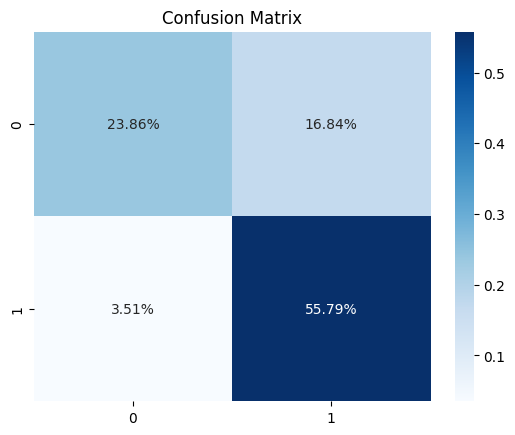

In [33]:
matrix = confusion_matrix(test_y,y_pred)
sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues').set(title="Confusion Matrix")
print(classification_report(test_y,y_pred))
plt.show()
print()

In [34]:
tes_kalimat = ['jokowi dilantik jadi presiden']

In [35]:
## Ingat Benar = 0, Hoax = 1

In [36]:
test = tfidf_vect_8020.transform(tes_kalimat)

In [37]:
print(test)

  (0, 7323)	0.42981987101130287
  (0, 3489)	0.4548128320654963
  (0, 1990)	0.7800001065848581


In [38]:
pred = best_model.predict(test)
pred

array([0])

In [39]:
tes_kalimat = ['Cak Imin Sapa Prabowo di Harlah PKB: Kita Sudah Koalisi 11 Bulan Lamanya']
test = tfidf_vect_8020.transform(tes_kalimat)
pred = best_model.predict(test)
pred

array([0])

In [40]:
tes_kalimat = ['Lando menjadi presiden indonesia']
test = tfidf_vect_8020.transform(tes_kalimat)
pred = best_model.predict(test)
pred

array([1])

In [41]:
joblib.dump(tfidf_vect_8020, 'tfidf_vectorizer.pkl')
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']